In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
import joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
tqdm.pandas()

In [4]:
df = pd.read_csv('../data/comments_data.csv')

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,English
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,English
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,English
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,English
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,English


In [6]:
df.info()
# No NaN values observed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220653 entries, 0 to 220652
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             220653 non-null  object
 1   comment_text   220653 non-null  object
 2   toxic          220653 non-null  int64 
 3   severe_toxic   220653 non-null  int64 
 4   obscene        220653 non-null  int64 
 5   threat         220653 non-null  int64 
 6   insult         220653 non-null  int64 
 7   identity_hate  220653 non-null  int64 
 8   lang           220653 non-null  object
dtypes: int64(6), object(3)
memory usage: 15.2+ MB


In [7]:
df.nunique()

id               220653
comment_text     220653
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
lang                  1
dtype: int64

# What We Have

Now, we have several columns:
- id: The comment identifier
- comment_txt: Text in the comment
- toxic: comment is toxic or not
- severe_toxic: comment is severely toxic or not
- obscene: comment is obscene or not
- threat: comment is threat or not
- insult: comment is insult or not
- identity_hate: comment is identity_hate or not
- lang: language

It seems we have multiple targets here. Now, let's count the frequency ratio of each target

In [8]:
targets = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [9]:
# We want to count the number of "yes" in each target and divide by the number of observation
def count_ratio(df, targets):
    ratio_dict = {}
    for target in targets:
        ratio_dict[target] = df[target].sum()/len(df)
    return ratio_dict

In [10]:
count_ratio(df,targets)

{'toxic': 0.09495905335526823,
 'severe_toxic': 0.00848844112701844,
 'obscene': 0.053541080338812524,
 'threat': 0.003099889872333483,
 'insult': 0.05013301428034062,
 'identity_hate': 0.009349521647111074}

Or, more elegant way:

In [11]:
df[targets].mean().sort_values(ascending=False)

toxic            0.094959
obscene          0.053541
insult           0.050133
identity_hate    0.009350
severe_toxic     0.008488
threat           0.003100
dtype: float64

Dang, we have an imbalanced problem here.

It seems that toxic is the most frequent. But is 'toxic' a generalization from the others?

In [12]:
df.iloc[0][targets]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: object

In [13]:
def check_generalization(df, targets):
    """
    Checking if there any rows that non-toxic but belongs to other categories.
    We want to know if "toxic" is the generalization from the others.
    """
    counter = 0
    targets = targets[1:]  #remove "toxic"

    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):  # iterate over dataframe, add progress bar
        toxic = row['toxic']   # get the toxic value
        other = row[targets].sum()  # sum all the others
        if toxic:  # if toxic, then let it go
            pass
        else:  # if non-toxic and the other is non zero then add the counter
            if other != 0:
                counter += 1
    return counter / len(df[df.toxic == 1])

In [14]:
check_generalization(df,targets)

100%|████████████████████████████████████████████████████████████████████████| 220653/220653 [02:24<00:00, 1530.01it/s]


0.051018947167470054

Well, it seems toxic is not a generalizaton because there are cases where non-toxic but belong to other class(es).

For this case, we should use the multi-label classification approach. However, for the sake of simplicity of this example. Let's stick only to `toxic`.

So later, we'll drop the other targets.

## Train-test-valid split

Before we go further, let's stop here and go back to the presentation again.

So, before we do anything that can alter the dataset, we should split our dataset first to prevent any data leakage. 

In [15]:
# Now, let's separate the features and target columns
def split_xy(df, x_col, y_col):
    x_col = ['id']+x_col
    y_col = ['id']+y_col
    return df[x_col], df[y_col]

In [16]:
x_all, y_all = split_xy(df, ['comment_text'], ['toxic'])

The Features and target now separated, let's split the train-test-valid

In [17]:
def get_stratify_col(y, stratify_col):
    if stratify_col is None:
        stratification = None
    else:
        stratification = y[stratify_col]
    
    return stratification

In [18]:
def run_split_data(x, y, stratify_col=None, TEST_SIZE=0.2):
    
    strat_train = get_stratify_col(y, stratify_col)
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                       stratify = strat_train,
                                       test_size= TEST_SIZE*2,
                                       random_state= 42)
    
    strat_test = get_stratify_col(y_test, stratify_col)
    x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test,
                                       stratify = strat_test,
                                       test_size= 0.5,
                                       random_state= 42)
    
    return x_train, y_train, x_valid, y_valid, x_test, y_test

Actually, there are some schemes can be used:
- Split train:test with 0.8:0.2 then split the splitted train into train:valid with 0.8:0.2
- Split train:valid:test with 0.8:0.2:0.2 like shown in the code above

It's arbitrary

Question:
- Why we need stratification? [answer](https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn#:~:text=As%20such%2C%20it%20is%20desirable,a%20stratified%20train%2Dtest%20split.)
- Can stratification works with multi-label? [answer](https://stackoverflow.com/questions/52434568/how-to-pickle-a-sklearn-pipeline-for-multi-label-classifier-one-vs-rest-classifi)

In [19]:
x_train, y_train,x_valid, y_valid,x_test, y_test = run_split_data(x_all, y_all, 'toxic', 0.2)

In [20]:
print(f"Ratio in training data: {y_train['toxic'].mean()}")
print(f"Ratio in validation data: {y_valid['toxic'].mean()}")
print(f"Ratio in testing data: {y_test['toxic'].mean()}")

Ratio in training data: 0.09496113784169619
Ratio in validation data: 0.09496725657700936
Ratio in testing data: 0.09494459676871134


In [21]:
print(f"Length training data: {len(x_train)}")
print(f"Length validation data: {len(x_valid)}")
print(f"Length testing data: {len(x_test)}")

Length training data: 132391
Length validation data: 44131
Length testing data: 44131


It's important to save the intermediate result. This can be very useful for debugging in the production stage. 

In [22]:
joblib.dump(x_train, "../output/x_train.pkl")
joblib.dump(y_train, "../output/y_train.pkl")
joblib.dump(x_valid, "../output/x_valid.pkl")
joblib.dump(y_valid, "../output/y_valid.pkl")
joblib.dump(x_test, "../output/x_test.pkl")
joblib.dump(y_test, "../output/y_test.pkl")

['../output/y_test.pkl']

# Data Preprocessing

In the previous steps, we only have `comment_text` as our only features. Thus, the possible next step is to **generate new features**.

But before we proceed to that step, we'd like to perform data processing.

## Lower Characters

What we want to do here is to make all of the characters in the `comment_text` in lowercase. Why?
- Standardizing all text
- Because computer will treat "Bekasi" and "bekasi" as different thing
- Thus, that can caused problem in the word vectorizer. Because "Bekasi" and "bekasi" will be different.

In [23]:
def lowercase_char(df_in):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].str.lower()
    return df

In [24]:
x_train_lower = lowercase_char(x_train)

In [25]:
x_train_lower.head()

,id,comment_text
162870,10c4b10bd953900d,""" \n\n :::you're splitting hairs - the idea th..."
170883,31ad9c8987c1a64c,:i simply undid your edit that removed sourced...
175275,436b574a54215710,""" \n\n == resident evil mention... == \n\n i'd..."
28519,4bda577fb3caa772,troops off to re-register
36661,6258dbad0e1b24da,"""\n\ni fixed some grammar. just basic things t..."


In [26]:
x_train.head()

,id,comment_text
162870,10c4b10bd953900d,""" \n\n :::You're splitting hairs - the idea th..."
170883,31ad9c8987c1a64c,:I simply undid your edit that removed sourced...
175275,436b574a54215710,""" \n\n == Resident Evil mention... == \n\n I'd..."
28519,4bda577fb3caa772,troops off to re-register
36661,6258dbad0e1b24da,"""\n\nI fixed some grammar. Just basic things t..."


## Decontracting words

Expanding words such as "'t to not", "'re to are". Why?
- Making text more consistent

In [27]:
# https://stackoverflow.com/a/47091490/14472314
def phrase_decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
def decontract(df_in):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(phrase_decontraction)
    return df

In [29]:
x_train_decontract = decontract(x_train_lower)

100%|███████████████████████████████████████████████████████████████████████| 132391/132391 [00:02<00:00, 47127.52it/s]


In [30]:
x_train_decontract.head()

,id,comment_text
162870,10c4b10bd953900d,""" \n\n :::you are splitting hairs - the idea t..."
170883,31ad9c8987c1a64c,:i simply undid your edit that removed sourced...
175275,436b574a54215710,""" \n\n == resident evil mention... == \n\n i w..."
28519,4bda577fb3caa772,troops off to re-register
36661,6258dbad0e1b24da,"""\n\ni fixed some grammar. just basic things t..."


In [31]:
x_train_lower.head()

,id,comment_text
162870,10c4b10bd953900d,""" \n\n :::you're splitting hairs - the idea th..."
170883,31ad9c8987c1a64c,:i simply undid your edit that removed sourced...
175275,436b574a54215710,""" \n\n == resident evil mention... == \n\n i'd..."
28519,4bda577fb3caa772,troops off to re-register
36661,6258dbad0e1b24da,"""\n\ni fixed some grammar. just basic things t..."


## Removing numbers

Numbers should not affect the toxicity of a comment. Thus, we want to remove the numbers

In [32]:
def remove_numbers(df_in):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: ''.join(string for string in x if not string.isdigit()))
    return df

In [33]:
x_train_nonum = remove_numbers(x_train_decontract)

100%|███████████████████████████████████████████████████████████████████████| 132391/132391 [00:07<00:00, 16883.27it/s]


In [34]:
x_train_nonum

,id,comment_text
162870,10c4b10bd953900d,""" \n\n :::you are splitting hairs - the idea t..."
170883,31ad9c8987c1a64c,:i simply undid your edit that removed sourced...
175275,436b574a54215710,""" \n\n == resident evil mention... == \n\n i w..."
28519,4bda577fb3caa772,troops off to re-register
36661,6258dbad0e1b24da,"""\n\ni fixed some grammar. just basic things t..."
...,...,...
644,01c10add8c4e0491,"well, you never answered my question about you..."
74556,c858e7772e89b5b5,"""\n dan, we do not repeat things that are mino..."
14097,2558cc6a8ad094eb,"""\nthis user has a limited history and is not ..."
199420,a76bd844beda1649,== template:navigation on meta tab colour == ...


# Remove punctuations

We can also consider punctuations as a noise.

In [35]:
def remove_punc(df_in):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].str.replace(f'[{punctuation}]', ' ', regex=True )
    return df

In [36]:
x_train_nopunc = remove_punc(x_train_nonum)

In [37]:
x_train_nopunc.head()

,id,comment_text
162870,10c4b10bd953900d,\n\n you are splitting hairs the idea t...
170883,31ad9c8987c1a64c,i simply undid your edit that removed sourced...
175275,436b574a54215710,\n\n resident evil mention \n\n i w...
28519,4bda577fb3caa772,troops off to re register
36661,6258dbad0e1b24da,\n\ni fixed some grammar just basic things t...


## Removing Whitespaces

Whitespace can also be considered as a noise. Moreover, we still have the newline characters "\n". We want to remove them.

In [38]:
def remove_whitespace(df_in):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: " ".join(x.split()))
    return df

In [39]:
x_train_nowhitespace = remove_whitespace(x_train_nopunc)

100%|███████████████████████████████████████████████████████████████████████| 132391/132391 [00:01<00:00, 93976.35it/s]


In [40]:
x_train_nowhitespace.head()

,id,comment_text
162870,10c4b10bd953900d,you are splitting hairs the idea that it could...
170883,31ad9c8987c1a64c,i simply undid your edit that removed sourced ...
175275,436b574a54215710,resident evil mention i would just like to add...
28519,4bda577fb3caa772,troops off to re register
36661,6258dbad0e1b24da,i fixed some grammar just basic things that we...


# Removing Stopwords

Stopwords are abundant, removing stopwords could give more focus to the important information.

Because the text is in english, we could use predefined stopwords from nltk

In [41]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghifa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghifa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
eng_stopwords = stopwords.words('english')

In [43]:
eng_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [44]:
def remove_stop(df_in, eng_stopwords):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: " ".join([word for word in nltk.word_tokenize(x) if word not in eng_stopwords]))
    return df

In [45]:
x_train_nostop = remove_stop(x_train_nowhitespace, eng_stopwords)

100%|████████████████████████████████████████████████████████████████████████| 132391/132391 [01:08<00:00, 1919.19it/s]


In [46]:
x_train_nostop.head()

,id,comment_text
162870,10c4b10bd953900d,splitting hairs idea could another barack obam...
170883,31ad9c8987c1a64c,simply undid edit removed sourced information ...
175275,436b574a54215710,resident evil mention would like add something...
28519,4bda577fb3caa772,troops register
36661,6258dbad0e1b24da,fixed grammar basic things incorrect — precedi...


## Stemming / Lemmatization

* **Goal:** reduce inflection in words to their root form.
* **Stemming:** Removing prefix or suffix (e.g. explanation --> explan)
* **Lemmatization:** Properly ensure the canonical form (e.g. explanation --> explain)

Sometimes stemming/lemmatization aren't necessary, but sometimes are helpful.

We don't know the effect until we try. Later, we'll try without stemming/lemmatization.

But if you want to know how to use it:

> note: These process are much slower than stopwords removal

### Stemming

In [47]:
eng_stemmer = SnowballStemmer('english')

In [48]:
def stemmer(df_in, eng_stemmer):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: " ".join([eng_stemmer.stem(word) for sent_words in nltk.word_tokenize(x) for word in nltk.word_tokenize(sent_words)]))
    return df

In [49]:
x_train_stemmed = stemmer(x_train_nostop, eng_stemmer)

100%|█████████████████████████████████████████████████████████████████████████| 132391/132391 [09:16<00:00, 237.83it/s]


In [50]:
x_train_stemmed.head()

,id,comment_text
162870,10c4b10bd953900d,split hair idea could anoth barack obama ridic...
170883,31ad9c8987c1a64c,simpli undid edit remov sourc inform without e...
175275,436b574a54215710,resid evil mention would like add someth bette...
28519,4bda577fb3caa772,troop regist
36661,6258dbad0e1b24da,fix grammar basic thing incorrect — preced jmi...


### Lemmatization

In [51]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghifa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ghifa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [52]:
wordnet_lemmatizer = WordNetLemmatizer()

In [53]:
def lemmatizer(df_in, eng_lemmatizer):
    df = df_in.copy()  # Avoid modifying the main dataframe
    df['comment_text'] = df['comment_text'].progress_apply(lambda x: " ".join([eng_lemmatizer.lemmatize(word, pos='v') for sent_words in nltk.word_tokenize(x) for word in nltk.word_tokenize(sent_words)]))
    return df

In [54]:
x_train_lemmatized = lemmatizer(x_train_nostop, wordnet_lemmatizer)

100%|█████████████████████████████████████████████████████████████████████████| 132391/132391 [08:09<00:00, 270.35it/s]


In [55]:
x_train_lemmatized

,id,comment_text
162870,10c4b10bd953900d,split hairs idea could another barack obama ri...
170883,31ad9c8987c1a64c,simply undo edit remove source information wit...
175275,436b574a54215710,resident evil mention would like add something...
28519,4bda577fb3caa772,troop register
36661,6258dbad0e1b24da,fix grammar basic things incorrect — precede j...
...,...,...
644,01c10add8c4e0491,well never answer question specific intention ...
74556,c858e7772e89b5b5,dan repeat things minority opinions obviously ...
14097,2558cc6a8ad094eb,user limit history register user reply instead...
199420,a76bd844beda1649,template navigation meta tab colour hi thehelp...


## Recap

In [56]:
def main_preprocess(df_in, eng_stopwords):
    df = df_in.copy()
    df = lowercase_char(df)
    df = decontract(df)
    df = remove_numbers(df)
    df = remove_punc(df)
    df = remove_whitespace(df)
    df = remove_stop(df, eng_stopwords)
    return df

In [57]:
x_list = [x_train,x_valid,x_test]

In [ ]:
x_preprocessed = []
for x in tqdm(x_list):
    temp = main_preprocess(x, eng_stopwords)
    x_preprocessed.append(temp)

In [59]:
name = ['train','valid','test']
for i,x in tqdm(enumerate(x_preprocessed)):
    joblib.dump(x, f"../output/x_{name[i]}_preprocessed.pkl")

3it [00:00, 13.86it/s]


# EDA

We want to analyze the text in order to understand more the case's context. Sometimes, EDA will also helps us to give new idea for new features.

In [60]:
x_train_preprocessed, x_valid_preprocessed, x_test_preprocessed = x_preprocessed

In [61]:
vec_toxic = CountVectorizer(stop_words=stopwords.words('english'))
x_toxic = vec_toxic.fit_transform(x_train_preprocessed[y_train.toxic == 1]['comment_text'])

In [62]:
vec_nontoxic = CountVectorizer(stop_words=stopwords.words('english'))
x_nontoxic = vec_nontoxic.fit_transform(x_train_preprocessed[y_train.toxic == 0]['comment_text'])

In [63]:
toxic_words = pd.DataFrame({
    'word': vec_toxic.get_feature_names_out(),
    'freq': np.array(x_toxic.sum(axis=0)).flatten()
})

In [64]:
nontoxic_words = pd.DataFrame({
    'word': vec_nontoxic.get_feature_names_out(),
    'freq': np.array(x_nontoxic.sum(axis=0)).flatten()
})

In [65]:
toxic_words.sort_values(by='freq', ascending=False).head(20)

,word,freq
10009,fuck,4224
10046,fucking,3025
14839,like,2910
27837,wikipedia,2528
24433,suck,2317
22763,shit,2259
17247,nigger,2171
10366,gay,1990
9106,fat,1986
1522,ass,1912


In [66]:
nontoxic_words.sort_values(by='freq', ascending=False).head(20)

,word,freq
8366,article,47509
145341,wikipedia,35065
96649,page,34884
146787,would,29296
129500,talk,25854
101372,please,23035
94385,one,22945
76497,like,20217
117466,see,16975
4274,also,16237


# Feature Engineering

In this section, we'll perform feature engineering. Because our main data is text, we won't do the numerical and image feature engineering here.

In [67]:
x_train_preprocessed, x_valid_preprocessed, x_test_preprocessed = x_preprocessed

So, what can we do with text data?

- Add new features:
  - Count-based features
    - Number of unique words / n_words in text: Toxic comments might use repetitive negative words. Can be helpful(?)
    - Number of punctuations: Maybe number of exclamation point? Toxic comments might used many of these.
    - Ratio of uppercase words: Offensive comment might use more uppercase. "blablabla FCK YOU PIECE OF SHT blablbla"
    - etc. (explore features that might help your model as many as possible)
  - Score-based features
    - Text polarity
    - Text subjectivity
  - Language features
    - part-of-speech (POS) tagging
    - Dependency parsing

- Converting text to vectors:
  - Bag of words
  - TF-IDF (We'll use this)
  - Word Embedding
 
Now for simplicity, we'll use the **TF-IDF** only. 

Some count-based features must be done parallel with data preprocessing. Because in the previous data preprocessing step, we have lowercased the text, removed punctuations, etc.

We could do the text polarity and subjectivity, but let's put them aside first.

Language features are also feasible to be added. But it's too complex and it seems won't help that much.

When you are doing **real project** you might need to make some experiments for feature engineering. Feature engineering need to be done **iteratively** not **one pass**. 

But always do the **simplest** for 1st iteration. 

## TF-IDF

TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The significance increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).

Let's see how basic TF-IDF works

In [68]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english'
)
X_new = vectorizer.fit_transform(x_train_preprocessed['comment_text'])

Now, let's see the token in the vectorizer

In [69]:
vectorizer.get_feature_names_out()[:100]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
       'aaaaaaaaaaaaaaaaaaggggggggggggggggggggggggggggggggggggggggggggggg',
       'aaaaaaaaaaaahahahahahahaaaaaaaaaaaaaahahahahahaaaaaaaaaaaaaaahahahahaaaaaaaaaaaaaaaaaaaaaaa',
       'aaaaaaaaaaarrrrrrrrrggggggg', 'aaaaaaaaaah',
       'aaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaaadm',
       'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhh',
       'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
       'aaaaaaaarrrrrrrrgggggggghhhhhhhhh',
       'aaaaaaahhhhhhhhhhhhhhhhhhhhhhh

Some tokens are "meaningless". This is expected since we are using noisy text. For further reference, you might find more techniques discussed at workshops like the Workshop on Noisy User-generated Text. For now, let's explore the document frequency and see whether this might tell us something.

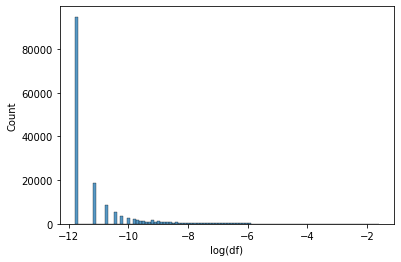

In [70]:
sns.histplot(
    x=np.log(np.array(X_new.astype(bool).mean(axis=0)).flatten()),
    bins=100
)
plt.xlabel('log(df)');

What are the most frequent occuring words and the least frequent?

In [71]:
# 10 most frequent
pd.DataFrame({
    'token': vectorizer.get_feature_names_out(),
    'df': np.array(X_new.astype(bool).mean(axis=0)).flatten()
}).sort_values('df').tail(10)

,token,df
138961,time,0.077853
41788,edit,0.080338
103495,people,0.081395
75891,know,0.091728
138137,think,0.102016
80036,like,0.131663
135307,talk,0.147669
151827,wikipedia,0.162798
101034,page,0.166129
8655,article,0.203541


In [72]:
# 10 least frequent
pd.DataFrame({
    'token': vectorizer.get_feature_names_out(),
    'df': np.array(X_new.astype(bool).mean(axis=0)).flatten()
}).sort_values('df').head(10)

,token,df
158406,𐌴𐌹,0.000008
82792,madhi,0.000008
82791,madhhabs,0.000008
82790,madhhab,0.000008
82789,madhesis,0.000008
82788,madhavpur,0.000008
82787,madhavan,0.000008
82786,madhani,0.000008
82785,madhai,0.000008
82784,madhab,0.000008


In `tf-idf` we can remove the most frequent and/or the least frequent by using `max_df` and `min_df` argument in [tf-idf vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This might affect the modeling result such as prevent overfitting.

But the question is: "What is the optimum value?"

Answer: we don't know, we could include this in the hyperparameter and optimize it. But now, let's try `min_df = 0.01`

In [73]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    min_df = 1e-2
)
x_new = vectorizer.fit_transform(x_train_preprocessed['comment_text'])

We aim to:
- Make the function reusable
- Fit vectorizer only to train data.
- Transform valid and test using the previous vectorizer

In [74]:
def vectorize_tfidf(df_in, vectorizer=None):
    df = df_in.copy()
    if vectorizer is None:  # fit to train data
        vectorizer = TfidfVectorizer(
            analyzer='word',
            stop_words='english',
            min_df = 1e-2
        )
        vectorized = vectorizer.fit_transform(df['comment_text'])
    else:
        vectorized = vectorizer.transform(df['comment_text'])
    
    vectorized_df = pd.DataFrame(vectorized.toarray(), 
                                 columns=vectorizer.get_feature_names(), 
                                 index = df.index)
    df_non_sentence = df.drop(['comment_text'],axis=1)
    df_final = pd.concat([vectorized_df, df_non_sentence],axis=1)
    return df_final, vectorizer

In [75]:
df_train_vect, vectorizer = vectorize_tfidf(x_train_preprocessed)

c:\users\ghifa\documents\pacmann\simple-ml-project-example\projectenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now, we must save the vectorizer transforming the valid and test. But now, because we're working in the same jupyter notebook file. We can directly use the vectorizer.

In [76]:
df_valid_vect, _ = vectorize_tfidf(x_valid_preprocessed, vectorizer)
df_test_vect, _ = vectorize_tfidf(x_test_preprocessed, vectorizer)

c:\users\ghifa\documents\pacmann\simple-ml-project-example\projectenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\ghifa\documents\pacmann\simple-ml-project-example\projectenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [77]:
df_train_vect

,able,according,account,actually,add,added,adding,address,admin,ago,...,write,writing,written,wrong,wrote,www,year,years,yes,id
162870,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,10c4b10bd953900d
170883,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,31ad9c8987c1a64c
175275,0.0,0.0,0.0,0.000000,0.275854,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,436b574a54215710
28519,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4bda577fb3caa772
36661,0.0,0.0,0.0,0.000000,0.000000,0.560699,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,6258dbad0e1b24da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,01c10add8c4e0491
74556,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.270539,0.0,0.0,0.0,0.0,0.0,c858e7772e89b5b5
14097,0.0,0.0,0.0,0.248332,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2558cc6a8ad094eb
199420,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,a76bd844beda1649


All is done! Well, id will not be used in modeling, later, the column `id` will be dropped.

In [78]:
joblib.dump(df_train_vect, f"../output/x_train_vect.pkl")
joblib.dump(df_valid_vect, f"../output/x_valid_vect.pkl")
joblib.dump(df_test_vect, f"../output/x_test_vect.pkl")

['../output/x_test_vect.pkl']